# Final Project - Coder School - Twitter User Gender Classification
## Predict user gender based on Twitter profile information

### Motivation:
- It is interesting, oddly interesting...
- Problem context is easily understandable
- There's already a popular classification problem based on Twitter text: Sentiment classification

In [2]:
# Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from sklearn_pandas import DataFrameMapper # Notice that this is actually Sklearn-Pandas library
%matplotlib inline

## About Dataset

This dataset is obtained from [Kaggle](https://www.kaggle.com/crowdflower/twitter-user-gender-classification/home).

The dataset contains 20,000 rows, each with a user name, a random tweet, account profile and image, location, and even link and sidebar color.

Attributes that do not provide useful information for _Gender classification_:
 - **_unit_id**: a unique id for user
 - **_last_judgment_at**: date and time of last contributor judgment; blank for gold standard observations
 - **user_timezone**: the timezone of the user
 - **tweet_coord**: if the user has location turned on, the coordinates as a string with the format "[latitude, longitude]"
 - **tweet_count**: number of tweets that the user has posted
 - **tweet_created**: when the random tweet (in the text column) was created
 - **tweet_id**: the tweet id of the random tweet
 - **tweet_location**: location of the tweet; seems to not be particularly normalized 
 - **profileimage**: a link to the profile image
 - **created**: date and time when the profile was created
 
 
Attributes that potentially provide useful information for _Gender classification_:
 - **_golden**: whether the user was included in the gold standard for the model; TRUE or FALSE
 - **_unit_state**: state of the observation; one of finalized (for contributor-judged) or golden (for gold standard observations)
 - **_trusted_judgments**: number of trusted judgments (int); always 3 for non-golden, and what may be a unique id for gold standard observations
 - **gender**: one of male, female, or brand (for non-human profiles)
 - **gender:confidence**: a float representing confidence in the provided gender
 - **gender_gold**: if the profile is golden, what is the gender?
 - **profile_yn**: "no" here seems to mean that the profile was meant to be part of the dataset but was not available when contributors went to judge it
 - **profile_yn:confidence**: confidence in the existence/non-existence of the profile
 - **profile_yn_gold**: whether the profile y/n value is golden
 - **description**: the user's profile description
 - **fav_number**: number of tweets the user has favorited
 - **link_color**: the link color on the profile, as a hex value
 - **name**: the user's name
 - **retweet_count**: number of times the user has retweeted (or possibly, been retweeted)
 - **sidebar_color**: color of the profile sidebar, as a hex value
 - **text**: text of a random one of the user's tweets


In [3]:
# Load dataset
data = pd.read_csv('gender_dataset.csv', encoding='latin-1')

# Drop unnecessary columns/features
data.drop (columns = ['_unit_id',
                      '_last_judgment_at',
                      'user_timezone',
                      'tweet_coord',
                      'tweet_count',
                      'tweet_created', 
                      'tweet_id',
                      'tweet_location',
                      'profileimage',
                      'created'], inplace = True)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20050 entries, 0 to 20049
Data columns (total 16 columns):
_golden                  20050 non-null bool
_unit_state              20050 non-null object
_trusted_judgments       20050 non-null int64
gender                   19953 non-null object
gender:confidence        20024 non-null float64
profile_yn               20050 non-null object
profile_yn:confidence    20050 non-null float64
description              16306 non-null object
fav_number               20050 non-null int64
gender_gold              50 non-null object
link_color               20050 non-null object
name                     20050 non-null object
profile_yn_gold          50 non-null object
retweet_count            20050 non-null int64
sidebar_color            20050 non-null object
text                     20050 non-null object
dtypes: bool(1), float64(2), int64(3), object(10)
memory usage: 2.3+ MB


In [5]:
data.head(3)

,_golden,_unit_state,_trusted_judgments,gender,gender:confidence,profile_yn,profile_yn:confidence,description,fav_number,gender_gold,link_color,name,profile_yn_gold,retweet_count,sidebar_color,text
0,False,finalized,3,male,1.0000,yes,1.0,i sing my own rhythm.,0,NaN,08C2C2,sheezy0,NaN,0,FFFFFF,Robbie E Responds To Critics After Win Against...
1,False,finalized,3,male,1.0000,yes,1.0,I'm the author of novels filled with family dr...,68,NaN,0084B4,DavdBurnett,NaN,0,C0DEED,ÛÏIt felt like they were my friends and I was...
2,False,finalized,3,male,0.6625,yes,1.0,louis whining and squealing and all,7696,NaN,ABB8C2,lwtprettylaugh,NaN,1,C0DEED,i absolutely adore when louis starts the songs...


## Cleaning Dataset

### 'Gender' Attribute (gender)

In [6]:
data['gender'].value_counts()
# We can see that there are 1117 unknown genders, so get rid of them

female     6700
male       6194
brand      5942
unknown    1117
Name: gender, dtype: int64

In [7]:
drop_items_idx = data[data['gender'] == 'unknown'].index

data.drop (index = drop_items_idx, inplace = True)

data['gender'].value_counts()

female    6700
male      6194
brand     5942
Name: gender, dtype: int64

### 'Profile' Attribute (profile_yn, profile_yn:confidence, profile_yn_gold)

**'No'**: Profile was meant to be part of the dataset but was not available when contributors went to judge it.

In [8]:
print ('profile_yn information:\n',data['profile_yn'].value_counts())

data[data['profile_yn'] == 'no']['gender']

profile_yn information:
 yes    18836
no        97
Name: profile_yn, dtype: int64


109      NaN
137      NaN
496      NaN
582      NaN
679      NaN
749      NaN
1179     NaN
1664     NaN
1698     NaN
1963     NaN
2118     NaN
2245     NaN
2272     NaN
2377     NaN
2537     NaN
2596     NaN
2717     NaN
2751     NaN
2765     NaN
2886     NaN
2980     NaN
3190     NaN
3195     NaN
3219     NaN
3337     NaN
3381     NaN
3553     NaN
3791     NaN
3942     NaN
4008     NaN
        ... 
12103    NaN
12889    NaN
13007    NaN
14045    NaN
15018    NaN
15243    NaN
15270    NaN
15428    NaN
15450    NaN
15740    NaN
15921    NaN
16208    NaN
16365    NaN
16640    NaN
16886    NaN
16991    NaN
17114    NaN
17163    NaN
18001    NaN
18048    NaN
18063    NaN
18070    NaN
18122    NaN
18136    NaN
18303    NaN
18524    NaN
18700    NaN
18840    NaN
19773    NaN
19842    NaN
Name: gender, Length: 97, dtype: object

It is shown that all of 97 instances with **profile_yn** == **no** are all **NaN** in **gender**. 

Therefore, i get rid of these 97 instances. Also, i get rid of **profile_yn**, **profile_yn:confidence** and **profile_yn_gold** as they are not useful anymore.

In [9]:
drop_items_idx = data[data['profile_yn'] == 'no'].index

data.drop (index = drop_items_idx, inplace = True)

print (data['profile_yn'].value_counts())

data.drop (columns = ['profile_yn','profile_yn:confidence','profile_yn_gold'], inplace = True)

yes    18836
Name: profile_yn, dtype: int64


In [10]:
# Double check the data 
print (data['gender'].value_counts())

print ('---------------------------')
data.info()

female    6700
male      6194
brand     5942
Name: gender, dtype: int64
---------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 18836 entries, 0 to 20049
Data columns (total 13 columns):
_golden               18836 non-null bool
_unit_state           18836 non-null object
_trusted_judgments    18836 non-null int64
gender                18836 non-null object
gender:confidence     18836 non-null float64
description           15522 non-null object
fav_number            18836 non-null int64
gender_gold           50 non-null object
link_color            18836 non-null object
name                  18836 non-null object
retweet_count         18836 non-null int64
sidebar_color         18836 non-null object
text                  18836 non-null object
dtypes: bool(1), float64(1), int64(3), object(8)
memory usage: 1.9+ MB


### Low-confidence gender (gender:confidence)

I decide to keep only 100% confidence of labeling Gender and get rid of those < 100% confidence.

In [11]:
print ('Full data items: ', data.shape)
print ('Data with label-confidence < 100%: ', data[data['gender:confidence'] < 1].shape)

Full data items:  (18836, 13)
Data with label-confidence < 100%:  (5032, 13)


Here, i can observe that approximately **26.7%** (5032/18836) of labeled instances were lower 100% of confidence

Then, i get rid of those instances and the feature **gender:confidence** as it is now useful anymore.

In [12]:
drop_items_idx = data[data['gender:confidence'] < 1].index

data.drop (index = drop_items_idx, inplace = True)

print (data['gender:confidence'].value_counts())

data.drop (columns = ['gender:confidence'], inplace = True)

1.0    13804
Name: gender:confidence, dtype: int64


### Get rid of remaining useless features

In [13]:
data.drop (columns = ['_golden','_unit_state','_trusted_judgments','gender_gold'], inplace = True)

# Double check the data 
print (data['gender'].value_counts())

print ('---------------------------')
data.info()

female    5367
male      4653
brand     3784
Name: gender, dtype: int64
---------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 13804 entries, 0 to 20049
Data columns (total 8 columns):
gender           13804 non-null object
description      11773 non-null object
fav_number       13804 non-null int64
link_color       13804 non-null object
name             13804 non-null object
retweet_count    13804 non-null int64
sidebar_color    13804 non-null object
text             13804 non-null object
dtypes: int64(2), object(6)
memory usage: 970.6+ KB


## Manipulate Text data

### Removing stop-words in Twits

First we need to take a glance at the most common words

In [14]:
from collections import Counter

twit_vocab = Counter()
for twit in data['text']:
    for word in twit.split(' '):
        twit_vocab[word] += 1
        
# desc_vocab = Counter()
# for twit in data['description']:
#     for word in twit.split(' '):
#         desc_vocab[word] += 1
        
twit_vocab.most_common(20)
# desc_vocab.most_common(20)

[('the', 8370),
 ('and', 7964),
 ('to', 4196),
 ('I', 3229),
 ('a', 3064),
 ('of', 2741),
 ('in', 2270),
 ('you', 2173),
 ('for', 2157),
 ('The', 2018),
 ('is', 1878),
 ('on', 1621),
 ('my', 1362),
 ('it', 1205),
 ('', 1184),
 ('with', 1156),
 ('Weather', 1074),
 ('that', 1032),
 ('from', 1022),
 ('me', 1001)]

As you can see, the most common words are meaningless in terms of sentiment: _I, to, the, and..._ . They're basically noise that can most probably be eliminated. These kind of words are called **stop words**, and it is a common practice to remove them when doing text analysis.

In [15]:
import nltk

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [16]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

twit_vocab_reduced = Counter()
for w, c in twit_vocab.items():
    if not w in stop:
        twit_vocab_reduced[w]=c

twit_vocab_reduced.most_common(20)

[('I', 3229),
 ('The', 2018),
 ('', 1184),
 ('Weather', 1074),
 ('-', 767),
 ("I'm", 651),
 ('like', 628),
 ('Get', 627),
 ('get', 570),
 ('Updates', 538),
 ('Channel.', 537),
 ('And', 487),
 ('one', 416),
 ('&amp;', 348),
 ('new', 343),
 ('love', 340),
 ('people', 315),
 ('time', 301),
 ('go', 290),
 ('know', 288)]

### Removing special characters and "trash"

We still se a very uneaven distribution. If you look closer, you'll see that we're also taking into consideration punctuation signs ('-', ',', etc) and other html tags like `&amp`. We can definitely remove them for the sentiment analysis, but we will try to keep the emoticons, since those _do_ have a sentiment load:

In [17]:
import re

def preprocessor(text):
    """ Return a cleaned version of text
    """
    # Remove HTML markup
    text = re.sub('<[^>]*>', '', text)
    # Save emoticons for later appending
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    # Remove any non-word character and append the emoticons,
    # removing the nose character for standarization. Convert to lower case
    text = (re.sub('[\W]+', ' ', text.lower()) + ' ' + ' '.join(emoticons).replace('-', ''))
    
    return text

print(preprocessor('This!!@ twit :) is <b>nice</b>'))

this twit is nice :)


### Lemmatization

We are almost ready! There is another trick we can use to reduce our vocabulary and consolidate words. If you think about it, words like: love, loving, etc. _Could_ express the same positivity. If that was the case, we would be  having two words in our vocabulary when we could have only one: lov. This process of reducing a word to its root is called **stemming**. An alternative way is called **Lemmatization**.

A popular stemming algorithm for English is **Porter** algorithm.

We also need a _tokenizer_ to break down our twits in individual words. We will implement two tokenizers, a regular one and one that does steaming:

In [18]:
from nltk.stem import PorterStemmer

porter = PorterStemmer()

def tokenizer(text):
    return text.split()

def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

print(tokenizer('Hi there, I am loving this, like with a lot of love'))
print(tokenizer_porter('Hi there, I am loving this, like with a lot of love'))

['Hi', 'there,', 'I', 'am', 'loving', 'this,', 'like', 'with', 'a', 'lot', 'of', 'love']
['Hi', 'there,', 'I', 'am', 'love', 'this,', 'like', 'with', 'a', 'lot', 'of', 'love']


## Visualize Data

Among text data, i want to find out if other features can give me useful information or show some special characteristics.

### Create a countplot to visualize the amount of each label

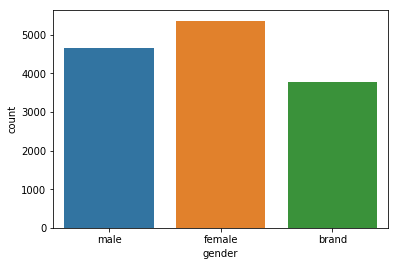

In [19]:
sns.countplot(data['gender'],label="Gender")

### Create a bar plot to visualize the amount of *favorites* and *retweets*

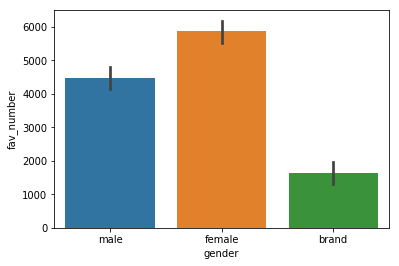

In [20]:
sns.barplot (x = 'gender', y = 'fav_number',data = data)

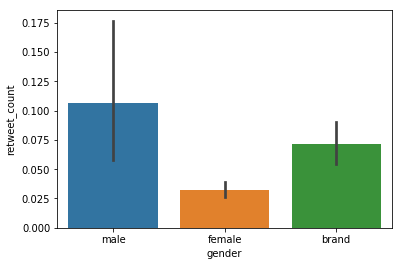

In [21]:
sns.barplot (x = 'gender', y = 'retweet_count',data = data)

### Visualize Colors attribute

['C0DEED' 'FFFFFF' '000000' 'EEEEEE' '181A1E' 'A8C7F7' '5ED4DC']


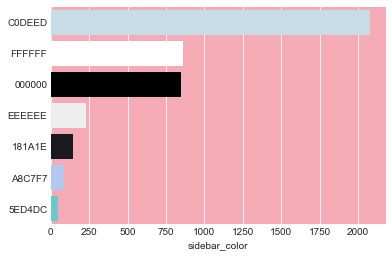

In [23]:
male_top_sidebar_color = data[data['gender'] == 'male']['sidebar_color'].value_counts().head(7)
male_top_sidebar_color_idx = male_top_sidebar_color.index
male_top_color = male_top_sidebar_color_idx.values

male_top_color[2] = '000000'
print (male_top_color)
l = lambda x: '#'+x

sns.set_style("darkgrid", {"axes.facecolor": "#F5ABB5"})
sns.barplot (x = male_top_sidebar_color, y = male_top_color, palette=list(map(l, male_top_color)))

['C0DEED' 'FFFFFF' '000000' 'EEEEEE' '65B0DA' '5ED4DC' 'CC3366']


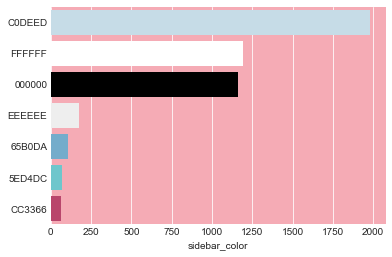

In [24]:
female_top_sidebar_color = data[data['gender'] == 'female']['sidebar_color'].value_counts().head(7)
female_top_sidebar_color_idx = female_top_sidebar_color.index
female_top_color = female_top_sidebar_color_idx.values

female_top_color[2] = '000000'
print (female_top_color)

l = lambda x: '#'+x

sns.set_style("darkgrid", {"axes.facecolor": "#F5ABB5"})
sns.barplot (x = female_top_sidebar_color, y = female_top_color, palette=list(map(l, female_top_color)))

For **sidebar color**, the top 3 colors of both male and female are the same (this seems to be these colors are default theme color of Twitter). It is shown that the number of 2nd and 3rd color of female is larger but this can be explained by the fact that the number of female users are more than male.

So, at this point, sidebar_color may not give me any useful information for classifying gender.

['0084B4' '009999' '3B94D9' '2FC2EF' 'DD2E44' '000000' 'ABB8C2']


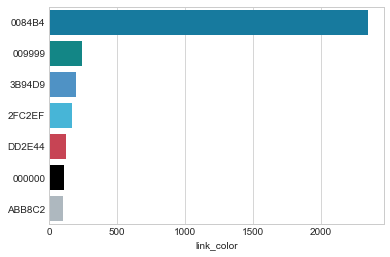

In [26]:
male_top_link_color = data[data['gender'] == 'male']['link_color'].value_counts().head(7)
male_top_link_color_idx = male_top_link_color.index
male_top_color = male_top_link_color_idx.values
male_top_color[1] = '009999'
male_top_color[5] = '000000'
print(male_top_color)

l = lambda x: '#'+x

sns.set_style("whitegrid", {"axes.facecolor": "white"})
sns.barplot (x = male_top_link_color, y = male_top_link_color_idx, palette=list(map(l, male_top_color)))

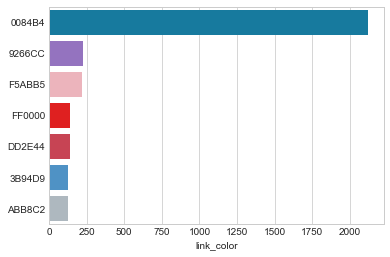

In [27]:
female_top_link_color = data[data['gender'] == 'female']['link_color'].value_counts().head(7)
female_top_link_color_idx = female_top_link_color.index
female_top_color = female_top_link_color_idx.values

l = lambda x: '#'+x

sns.set_style("whitegrid", {"axes.facecolor": "white"})
sns.barplot (x = female_top_link_color, y = female_top_link_color_idx, palette=list(map(l, female_top_color)))

## Training classification models with Tweet-text only

### How relevant are words? Term frequency-inverse document frequency

We could use these raw term frequencies to score the words in our algorithm. There is a problem though: If a word is very frequent in _all_ documents, then it probably doesn't carry a lot of information. In order to tacke this problem we can use **term frequency-inverse document frequency**, which will reduce the score the more frequent the word is accross all twits. It is calculated like this:

\begin{equation*}
tf-idf(t,d) = tf(t,d) ~ idf(t,d)
\end{equation*}

_tf(t,d)_ is the raw term frequency descrived above. _idf(t,d)_ is the inverse document frequency, than can be calculated as follows:

\begin{equation*}
\log \frac{n_d}{1+df\left(d,t\right)}
\end{equation*}

where `n` is the total number of documents (number of _twits_ in this problem) and _df(t,d)_ is the number of documents where the term `t` appears. 

The `1` addition in the denominator is just to avoid zero term for terms that appear in all documents. Ans the `log` ensures that low frequency term don't get too much weight.

The IDF (inverse document frequency) of a word is the measure of how significant that term is in the whole corpus (the whole collection of _twits_ in this problem).

The higher the TF-IDF weight value, the rarer the term. The smaller the weight, the more common the term.

Fortunately for us `scikit-learn` does all those calculations for us:

In [28]:
# Firstly, convert categorical labels into numerical ones
# Function for encoding categories
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y = encoder.fit_transform(data['gender'])


# split the dataset in train and test
X = data['text']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)
#In the code line above, stratify will create a train set with the same class balance than the original set

X_train.head()

19087    @rvpisarapist my players literally give 110% a...
11212    Backers of the atrium lobby considered joining...
14799    I was supposed to receive my @SpiritHalloween ...
6846     Depression comes when you least expect it, lik...
1226     Grimes Throws a Fun, Bloody Party in "Flesh Wi...
Name: text, dtype: object

### Try with Logistic Regression Model

In [29]:
from sklearn.linear_model import LogisticRegression

tfidf = TfidfVectorizer(lowercase=False,
                        tokenizer=tokenizer_porter,
                        preprocessor=preprocessor)
clf = Pipeline([('vect', tfidf),
                ('clf', LogisticRegression(multi_class='ovr', random_state=0))])

clf.fit(X_train, y_train)

predictions = clf.predict(X_test)
print('Accuracy:',accuracy_score(y_test,predictions))
print('Confusion matrix:\n',confusion_matrix(y_test,predictions))
print('Classification report:\n',classification_report(y_test,predictions))

Accuracy: 0.5999517141477547
Confusion matrix:
 [[ 872  116  148]
 [ 215 1051  344]
 [ 256  578  562]]
Classification report:
              precision    recall  f1-score   support

          0       0.65      0.77      0.70      1136
          1       0.60      0.65      0.63      1610
          2       0.53      0.40      0.46      1396

avg / total       0.59      0.60      0.59      4142



### Try with Random Forest

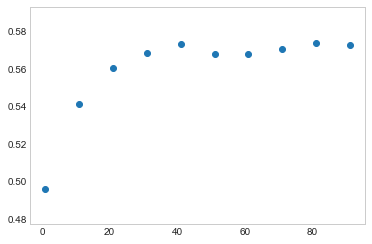

In [30]:
from sklearn.ensemble import RandomForestClassifier
# Plot the correlation between n_estimators and accuracy

# X_train_sample = X_train.head(5000) # this is series
# y_train_sample = y_train[:5000] # this is array

# print (X_train_sample.shape)
# print (y_train_sample.shape)

n = range (1,100,10) #step 10

results = []
for i in n:
    clf = Pipeline([('vect', tfidf),
                ('clf', RandomForestClassifier(n_estimators = i, random_state=0))])
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)
    results.append(accuracy_score(y_test, predictions))
plt.grid()
plt.scatter(n, results)

It is shown that with approximately **40** trees, Random Forest classifier starts reaching the highest performance.

In [31]:
tfidf = TfidfVectorizer(lowercase=False,
                        tokenizer=tokenizer_porter,
                        preprocessor=preprocessor)
clf = Pipeline([('vect', tfidf),
                ('clf', RandomForestClassifier(n_estimators = 40, random_state=0))])

clf.fit(X_train, y_train)

predictions = clf.predict(X_test)
print('Accuracy:',accuracy_score(y_test,predictions))
print('Confusion matrix:\n',confusion_matrix(y_test,predictions))
print('Classification report:\n',classification_report(y_test,predictions))

Accuracy: 0.570738773539353
Confusion matrix:
 [[ 700  259  177]
 [ 122 1195  293]
 [ 155  772  469]]
Classification report:
              precision    recall  f1-score   support

          0       0.72      0.62      0.66      1136
          1       0.54      0.74      0.62      1610
          2       0.50      0.34      0.40      1396

avg / total       0.57      0.57      0.56      4142



### Try with SVM

In [32]:
# the SVM model
from sklearn.svm import SVC

tfidf = TfidfVectorizer(lowercase=False,
                        tokenizer=tokenizer_porter,
                        preprocessor=preprocessor)
clf = Pipeline([('vect', tfidf),
                ('clf', SVC(kernel = 'linear'))])
clf.fit(X_train, y_train)

predictions = clf.predict(X_test)
print('Accuracy:',accuracy_score(y_test,predictions))
print('Confusion matrix:\n',confusion_matrix(y_test,predictions))
print('Classification report:\n',classification_report(y_test,predictions))

Accuracy: 0.598020280057943
Confusion matrix:
 [[ 858  117  161]
 [ 219 1010  381]
 [ 243  544  609]]
Classification report:
              precision    recall  f1-score   support

          0       0.65      0.76      0.70      1136
          1       0.60      0.63      0.62      1610
          2       0.53      0.44      0.48      1396

avg / total       0.59      0.60      0.59      4142



### Experimental Results

Accuracy:
 - **Logistic Regression**: 59.95%  
 - **Random Forest**: 57.07%  
 - **SVM**: 59.80%  
 
Winner: **Logistic Regression** model

## Adding content of Description into Text 

In [47]:
data.head(3)

,gender,description,fav_number,link_color,name,retweet_count,sidebar_color,text,text_description,fixed_link_color,009999,9266CC,F5ABB5,2FC2EF
0,male,i sing my own rhythm.,0,08C2C2,sheezy0,0,FFFFFF,Robbie E Responds To Critics After Win Against...,Robbie E Responds To Critics After Win Against...,08C2C2,0,0,0,0
1,male,I'm the author of novels filled with family dr...,68,0084B4,DavdBurnett,0,C0DEED,ÛÏIt felt like they were my friends and I was...,ÛÏIt felt like they were my friends and I was...,0084B4,0,0,0,0
3,male,"Mobile guy. 49ers, Shazam, Google, Kleiner Pe...",202,0084B4,douggarland,0,C0DEED,Hi @JordanSpieth - Looking at the url - do you...,Hi @JordanSpieth - Looking at the url - do you...,0084B4,0,0,0,0


### Concatenating 'description' to 'text'

In [33]:
#Fill NaN with empty string
data.fillna("", inplace = True)

# Concatenate text with description, add white space between. 
# By using Series helper functions Series.str()
data['text_description'] = data['text'].str.cat(data['description'], sep=' ')

data['text_description'].isnull().value_counts() # Check if any null values, True if there is at least one.

False    13804
Name: text_description, dtype: int64

### Re-create training dataset

In [34]:
# split the dataset in train and test
X = data['text_description']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)
#In the code line above, stratify will create a train set with the same class balance than the original set

X_train.head()
X_train.isnull().values.any() # Check if any null values, True if there is at least one.

False

### Try with Logistic Regression

In [35]:
from sklearn.linear_model import LogisticRegression

tfidf = TfidfVectorizer(lowercase=False,
                        tokenizer=tokenizer_porter,
                        preprocessor=preprocessor)
clf = Pipeline([('vect', tfidf),
                ('clf', LogisticRegression(multi_class='ovr', random_state=0))])

clf.fit(X_train, y_train)

predictions = clf.predict(X_test)
print('Accuracy:',accuracy_score(y_test,predictions))
print('Confusion matrix:\n',confusion_matrix(y_test,predictions))
print('Classification report:\n',classification_report(y_test,predictions))

Accuracy: 0.6817962337035248
Confusion matrix:
 [[ 959   80   97]
 [ 137 1192  281]
 [ 191  532  673]]
Classification report:
              precision    recall  f1-score   support

          0       0.75      0.84      0.79      1136
          1       0.66      0.74      0.70      1610
          2       0.64      0.48      0.55      1396

avg / total       0.68      0.68      0.67      4142



### Try with Random Forest

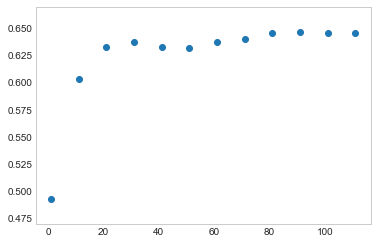

In [36]:
# Plot the correlation between n_estimators and accuracy

# X_train_sample = X_train.head(5000) # this is series
# y_train_sample = y_train[:5000] # this is array

# print (X_train_sample.shape)
# print (y_train_sample.shape)

n = range (1,120,10) #step 10

results = []
for i in n:
    clf = Pipeline([('vect', tfidf),
                ('clf', RandomForestClassifier(n_estimators = i, random_state=0))])
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)
    results.append(accuracy_score(y_test, predictions))
plt.grid()    
plt.scatter(n, results)

It is shown that with approximately **80** trees, Random Forest classifier starts reaching the highest performance.

In [37]:
from sklearn.ensemble import RandomForestClassifier

tfidf = TfidfVectorizer(lowercase=False,
                        tokenizer=tokenizer_porter,
                        preprocessor=preprocessor)
clf = Pipeline([('vect', tfidf),
                ('clf', RandomForestClassifier(n_estimators = 80, random_state=0))])

clf.fit(X_train, y_train)

predictions = clf.predict(X_test)
print('Accuracy:',accuracy_score(y_test,predictions))
print('Confusion matrix:\n',confusion_matrix(y_test,predictions))
print('Classification report:\n',classification_report(y_test,predictions))

Accuracy: 0.6438918396909705
Confusion matrix:
 [[ 883  147  106]
 [ 108 1339  163]
 [ 143  808  445]]
Classification report:
              precision    recall  f1-score   support

          0       0.78      0.78      0.78      1136
          1       0.58      0.83      0.69      1610
          2       0.62      0.32      0.42      1396

avg / total       0.65      0.64      0.62      4142



### Try with SVM

In [38]:
# the SVM model
from sklearn.svm import SVC

tfidf = TfidfVectorizer(lowercase=False,
                        tokenizer=tokenizer_porter,
                        preprocessor=preprocessor)
clf = Pipeline([('vect', tfidf),
                ('clf', SVC(kernel = 'linear'))])
clf.fit(X_train, y_train)

predictions = clf.predict(X_test)
print('Accuracy:',accuracy_score(y_test,predictions))
print('Confusion matrix:\n',confusion_matrix(y_test,predictions))
print('Classification report:\n',classification_report(y_test,predictions))

Accuracy: 0.6868662481892805
Confusion matrix:
 [[ 952   82  102]
 [ 117 1169  324]
 [ 178  494  724]]
Classification report:
              precision    recall  f1-score   support

          0       0.76      0.84      0.80      1136
          1       0.67      0.73      0.70      1610
          2       0.63      0.52      0.57      1396

avg / total       0.68      0.69      0.68      4142



### Experimental Results

Accuracy:
 - **Logistic Regression**: 68.17%  
 - **Random Forest**: 64.38%  
 - **SVM**: 68.68%  
 
Winner: **SVM** model

## Try Ensemble technique - Take advantage of both 3 models

In [40]:
from sklearn.ensemble import VotingClassifier
clf1 = LogisticRegression(multi_class='ovr', random_state=0)
clf2 = RandomForestClassifier(n_estimators = 80, random_state=0)
clf3 = SVC(kernel = 'linear',probability = True, random_state=0)

ensemble_clf = VotingClassifier(estimators=[
        ('lr', clf1), ('rf', clf2), ('svm', clf3)], voting='soft')

clf = Pipeline([('vect', tfidf),
                ('clf', ensemble_clf)])

clf.fit(X_train, y_train)

# ensemble_clf.fit(X_train, y_train)

predictions = clf.predict(X_test)
print('Accuracy:',accuracy_score(y_test,predictions))
print('Confusion matrix:\n',confusion_matrix(y_test,predictions))
print('Classification report:\n',classification_report(y_test,predictions))

Accuracy: 0.6897633993239981
Confusion matrix:
 [[ 960   84   92]
 [ 120 1241  249]
 [ 172  568  656]]
Classification report:
              precision    recall  f1-score   support

          0       0.77      0.85      0.80      1136
          1       0.66      0.77      0.71      1610
          2       0.66      0.47      0.55      1396

avg / total       0.69      0.69      0.68      4142



D:\Anaconda\Anaconda_3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


### Experimental Results

**The increase of accuracy is not significant at all - only 0.3% (68.68% - 68.97%)**. But it is worth running experiment since ensemble learning usually yields better results.

--> Maybe i need to research more to select precisely the classifiers for ensemble system in the futures.

# Conclusions

I implemented a system of Gender classification based on the dataset provided on Kaggle.
This is actually an interesting problem among with the Sentiment classification problem, which is more popular.

As I intended to implement classifiers based on Text data, i also wanted to explore whether other features can help the model classify Gender. Therefore, i plotted different graphs to visualize them. The results show that **link_color** may give additional useful information for classification task. 

The results show that Only the **Tweet text** can yield a moderate accuracy, although it's not sustantially high.
But with the content from the **Description**, the classifiers actually improve its performance significantly.

I also tried implementing Ensemble learning as one of my idea during the implementation, however, it only slightly increases the accuracy. 


## Future works

 - Re-implement ensemble learning system with further research
 - Extract link_color features to add to the models
 - Try applying Deep Learning (optional)